<a href="https://colab.research.google.com/github/vitfreire/LH_CD_VitoriaFreire/blob/main/LH_CD_Vit%C3%B3riaFreire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Análise de Negócio (EDA)

Esta parte foca na exploração dos dados para entender o cenário do negócio (aluguéis temporários em Nova York), com a visualização dos dados, estatísticas descritivas e análise dos pontos turísticos.

In [12]:
!pip install contextily
!pip install tqdm-joblib
!pip install category_encoders
!pip install
!pip install dask[dataframe]
!pip install fpdf

ERROR: You must give at least one requirement to install (see "pip help install")


Mounted at /content/drive

----------------------------------------
Visualização Inicial dos Dados:

+----+--------------------------------------------------+-------------+----------------+--------------+------------+-------------+-----------------+---------+-----------------+---------------------+-----------------+-------------------+---------------------------------+-----------------------+
|    | nome                                             | host_name   | bairro_group   | bairro       |   latitude |   longitude | room_type       |   price |   minimo_noites |   numero_de_reviews | ultima_review   |   reviews_por_mes |   calculado_host_listings_count |   disponibilidade_365 |
+====+==================================================+=============+================+==============+============+=============+=================+=========+=================+=====================+=================+===================+=================================+=======================+
|  0 | Skylit 

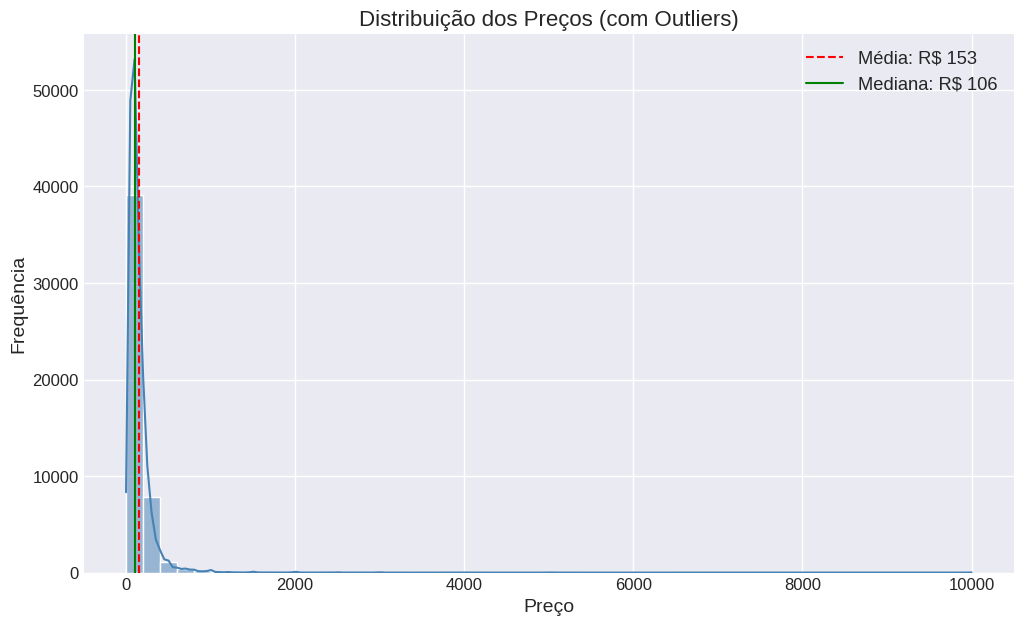



Explicação: Este gráfico apresenta a distribuição dos preços dos imóveis. A linha vermelha indica a média e a verde a mediana, ressaltando a presença de outliers.
Hipótese: Preços muito altos podem indicar nichos premium. O gráfico foi salvo como imagem para uso futuro.




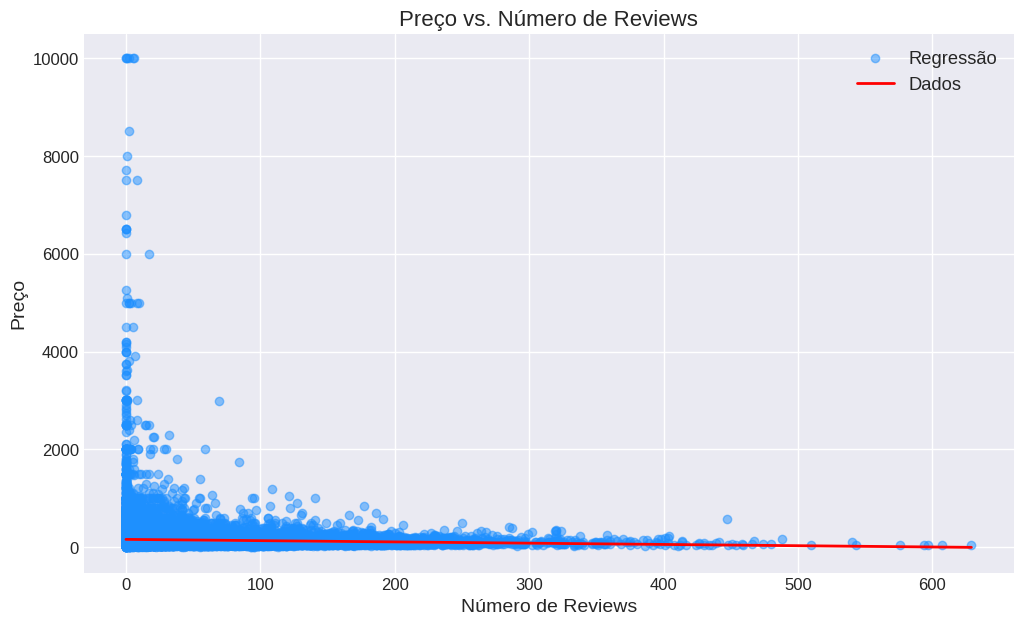



Explicação: Este gráfico de dispersão com linha de regressão mostra a relação entre o número de reviews e o preço.
Hipótese: Um alto número de reviews pode indicar alta demanda ou popularidade, refletindo preços diferenciados. O gráfico foi salvo como imagem para uso futuro.




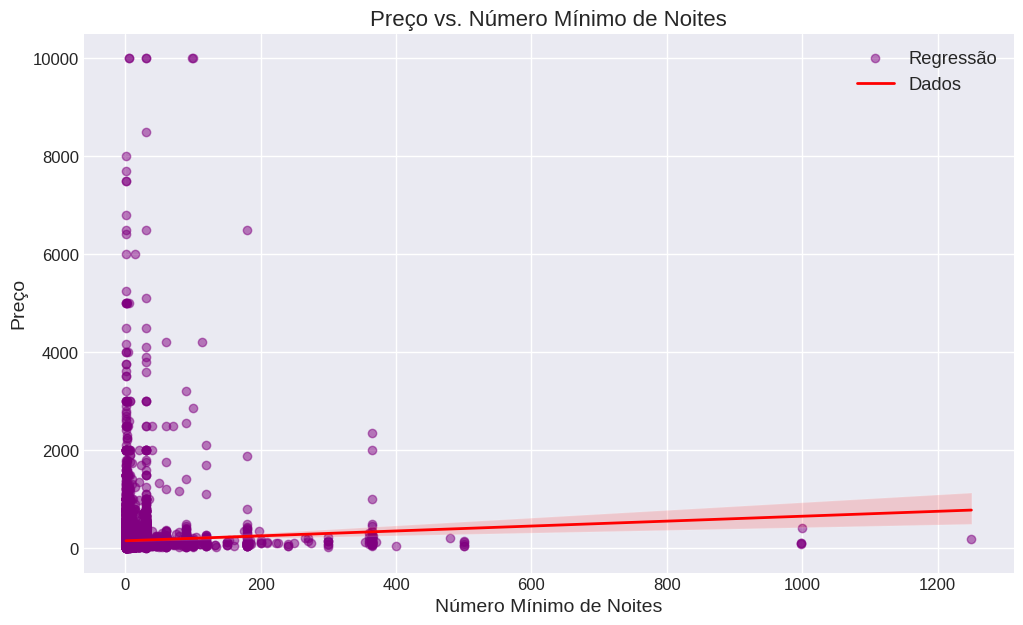



Explicação: Este gráfico investiga se um número mínimo maior de noites está associado a preços diferenciados.
Hipótese: Restrições de estadia podem direcionar o imóvel para um público específico, influenciando a precificação. O gráfico foi salvo como imagem para uso futuro.




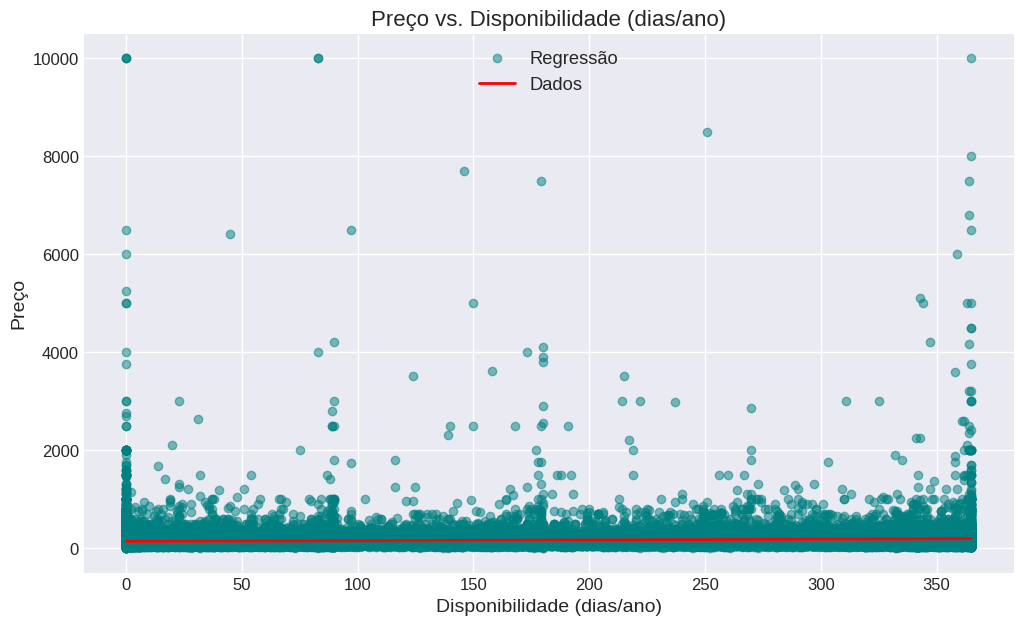



Explicação: Este gráfico avalia a influência da disponibilidade anual no preço.
Hipótese: Menor disponibilidade pode indicar alta demanda, elevando o preço. O gráfico foi salvo como imagem para uso futuro.




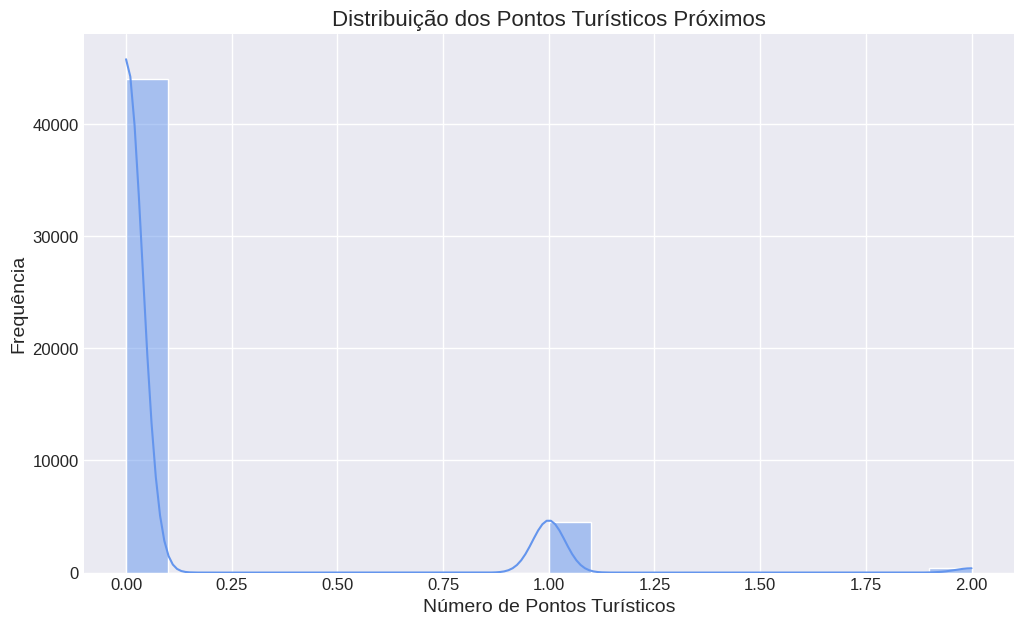



Explicação: Este histograma exibe a distribuição dos pontos turísticos próximos, indicando que imóveis próximos a atrações podem ser mais valorizados.
Hipótese: A proximidade de pontos turísticos pode agregar valor ao imóvel. O gráfico foi salvo como imagem para uso futuro.




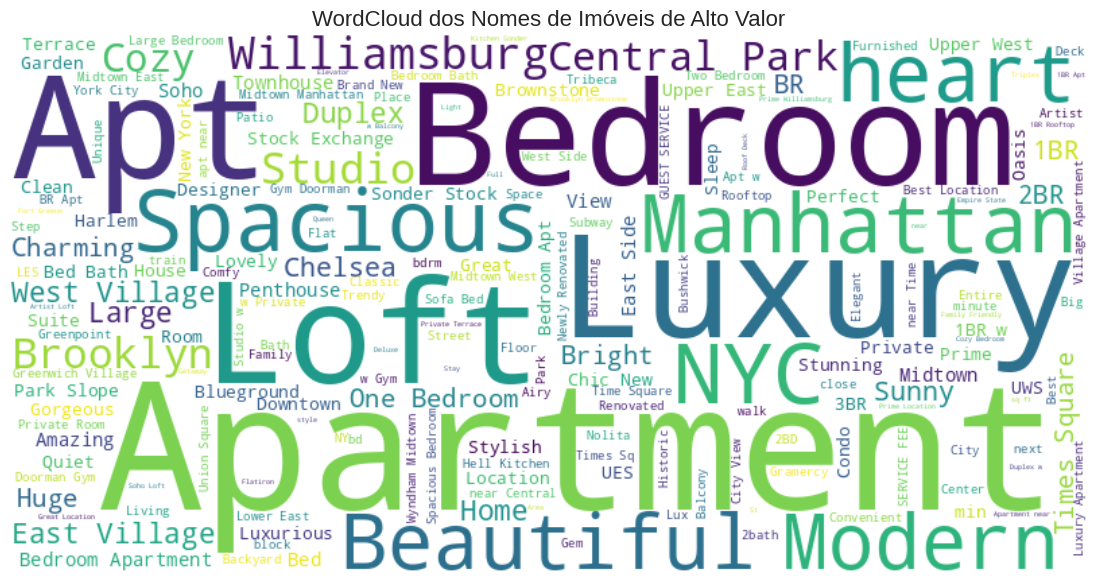



Explicação: A WordCloud destaca os termos mais frequentes em imóveis de alto valor.
Hipótese: Palavras como 'luxo', 'moderno', 'vista', 'central' e 'exclusivo' sugerem características premium. O gráfico foi salvo como imagem para uso futuro.




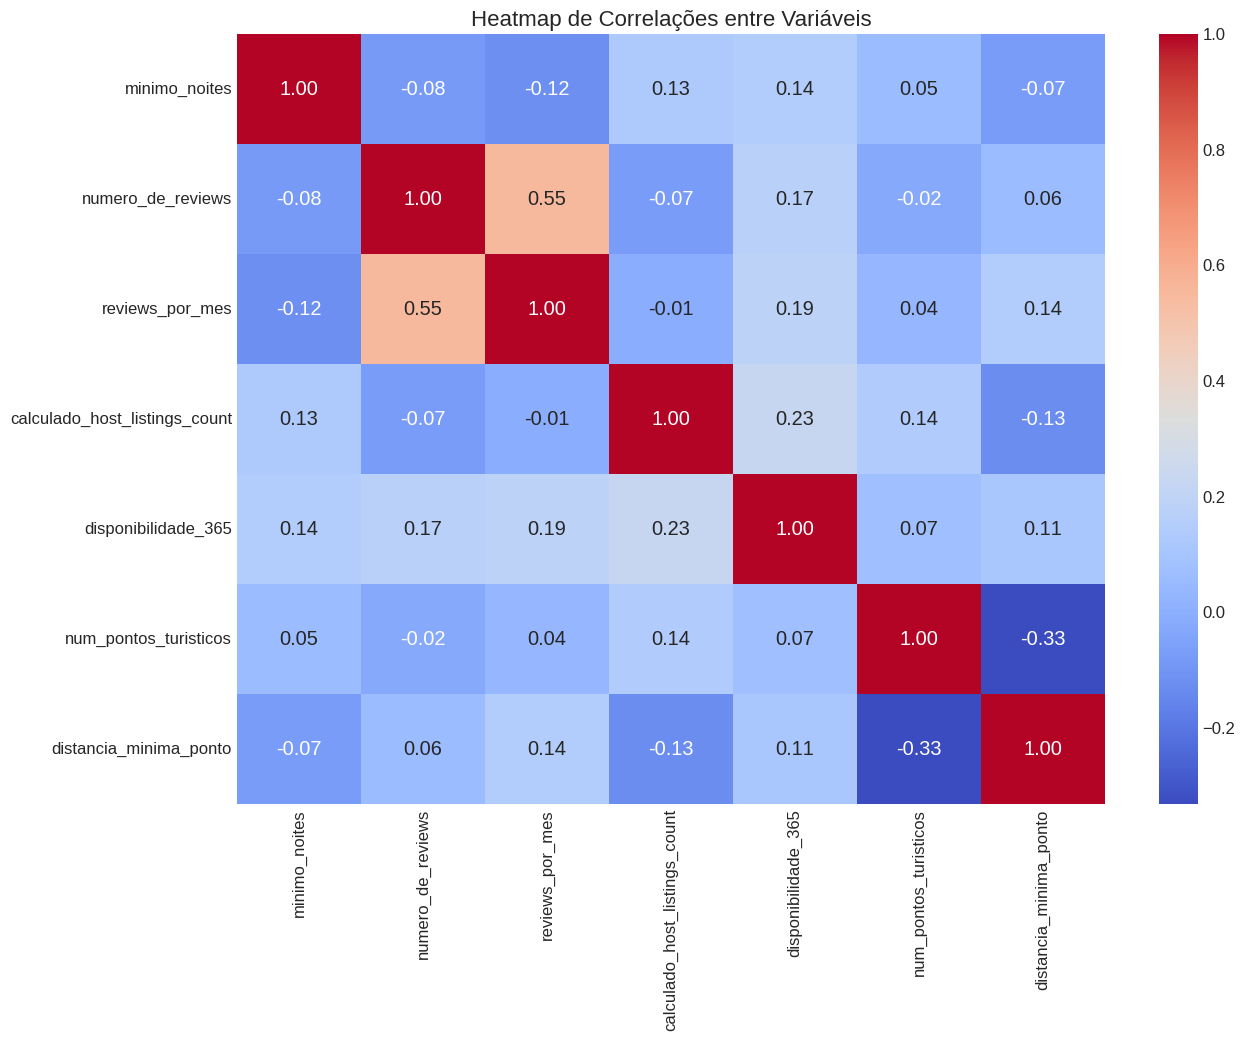



Explicação: O heatmap apresenta as correlações entre as variáveis.
Hipótese: Variáveis com forte correlação com o preço são determinantes na precificação. O gráfico foi salvo como imagem para uso futuro.




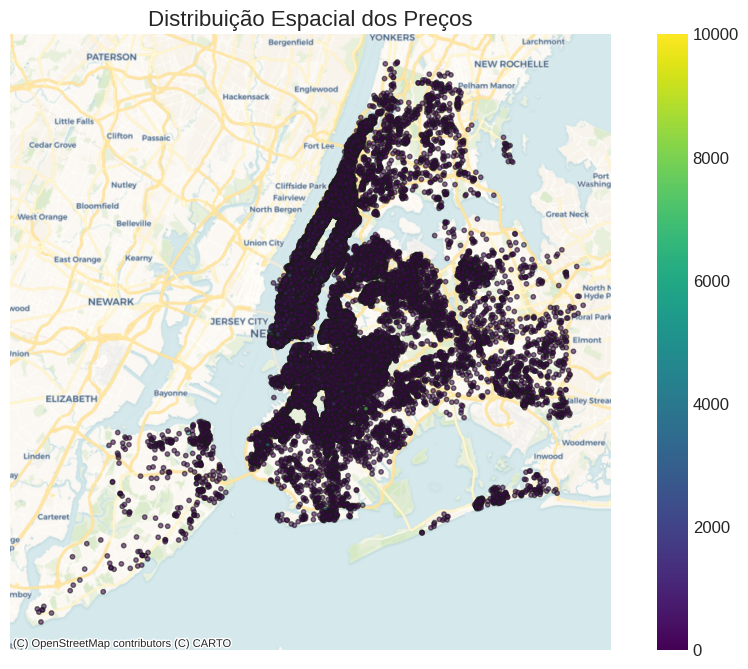



Explicação: Este mapa geoespacial mostra a distribuição dos preços conforme a localização dos imóveis.
Hipótese: Regiões centrais tendem a ter preços mais altos; áreas emergentes podem apresentar preços mais competitivos. O gráfico foi salvo como imagem para uso futuro.



Relatório salvo em: /content/drive/MyDrive/LH_CD/Relatorio_vit.pdf

=== DETALHAMENTO DO MODELO ===
Previsão do Preço e Detalhamento do Modelo:
1. Pipeline e Transformações:
   - Variáveis numéricas: minimo_noites, numero_de_reviews, reviews_por_mes, calculado_host_listings_count, disponibilidade_365,
     ano_ultima_review, dias_desde_ultima_review, num_pontos_turisticos e distancia_minima_ponto, padronizadas com StandardScaler.
   - Variáveis categóricas: room_type e bairro_group, transformadas com OneHotEncoder.
2. Tipo de Problema: Regressão (previsão de preço).
3. Modelo Utilizado: XGBRegressor.
   - Prós: Bom desempenho e flexibilidade.
   - Contras: Necessita ajuste cuidadoso de hiperparâmetros e pode apresen

In [11]:
# =============================================================================
# 1. IMPORTAÇÃO DE BIBLIOTECAS E CONFIGURAÇÃO INICIAL
# =============================================================================
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from fpdf import FPDF
from tabulate import tabulate
from google.colab import drive
import unicodedata

warnings.filterwarnings('ignore')

# Configuração do estilo dos gráficos
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Montar o Google Drive
drive.mount('/content/drive', force_remount=True)

# =============================================================================
# 2. DEFINIÇÃO DOS CAMINHOS E CARREGAMENTO DOS DADOS
# =============================================================================
file_path = "/content/drive/MyDrive/LH_CD/teste_indicium_precificacao.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Arquivo não encontrado: {file_path}")

df = pd.read_csv(file_path)
# Remover colunas indesejadas
for col in ['id', 'host_id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Exibir dados iniciais no console
print("\n" + "-"*40)
print("Visualização Inicial dos Dados:\n")
print(tabulate(df.head(), headers='keys', tablefmt='grid'))
print("\n" + "-"*40)
print("Estatísticas Descritivas:\n")
print(tabulate(df.describe().T, headers='keys', tablefmt='grid'))
print("\n" + "-"*40)
print("Contagem de Valores Ausentes:\n")
print(tabulate(pd.DataFrame(df.isnull().sum(), columns=["Valores Ausentes"]),
               headers='keys', tablefmt='grid'))
print("\n" + "-"*40)

# =============================================================================
# 3. CARREGAMENTO DOS DADOS DE PONTOS TURÍSTICOS
# =============================================================================
pontos_file = os.path.join(os.path.dirname(file_path), 'pontos_turisticos.csv')
if not os.path.exists(pontos_file):
    print("Arquivo de pontos turísticos não encontrado. Criando dataset de exemplo...")
    dados_pontos = {
        'nome': ['Estátua da Liberdade', 'Central Park', 'Times Square',
                 'Empire State Building', 'Brooklyn Bridge', 'Metropolitan Museum of Art'],
        'latitude': [40.6892, 40.7829, 40.7580, 40.7484, 40.7061, 40.7794],
        'longitude': [-74.0445, -73.9654, -73.9855, -73.9857, -73.9969, -73.9632]
    }
    pontos = pd.DataFrame(dados_pontos)
    pontos.to_csv(pontos_file, index=False)
else:
    pontos = pd.read_csv(pontos_file)

# Exibir informações dos pontos turísticos em formato de tabela
print("\n" + "-"*40)
print("Arquivo de pontos turísticos não encontrado. Criando dataset de exemplo...\n")
print("----- Primeiras 5 linhas dos Pontos Turísticos -----")
print(tabulate(pontos.head(), headers='keys', tablefmt='grid'))
print("\n----- Informações dos Pontos Turísticos -----")
info_pontos = []
for col in pontos.columns:
    info_pontos.append([col, pontos[col].count(), pontos[col].dtype])
print(tabulate(info_pontos, headers=["Coluna", "Non-Null Count", "Dtype"], tablefmt="grid"))
print("-"*40 + "\n")

# =============================================================================
# 4. CÁLCULO VETORIZADO DOS RECURSOS (PONTOS TURÍSTICOS)
# =============================================================================
lat_rad = np.radians(df['latitude'].values)
lon_rad = np.radians(df['longitude'].values)
dist_list = []
for idx, row in pontos.iterrows():
    lat2 = np.radians(row['latitude'])
    lon2 = np.radians(row['longitude'])
    dlat = lat2 - lat_rad
    dlon = lon2 - lon_rad
    a = np.sin(dlat/2.0)**2 + np.cos(lat_rad)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    km = 6371 * c
    dist_list.append(km)
distances = np.array(dist_list)  # Shape: (n_pontos, n_linhas)

df['num_pontos_turisticos'] = (distances <= 1.0).sum(axis=0)
df['distancia_minima_ponto'] = distances.min(axis=0)

print("Calculando novas features a partir dos pontos turísticos...")
print("----- Estatísticas dos novos recursos (Pontos Turísticos) -----")
print(tabulate(df[['num_pontos_turisticos', 'distancia_minima_ponto']].describe().T,
               headers='keys', tablefmt='grid'))

# =============================================================================
# 5. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)
# =============================================================================
graficos_dir = os.path.join(os.getcwd(), "/content/drive/MyDrive/LH_CD/graficos")
os.makedirs(graficos_dir, exist_ok=True)

def salva_e_fecha(fig, caminho):
    fig.savefig(caminho, dpi=300)
    plt.show()
    plt.close(fig)

# --- 5.1. DISTRIBUIÇÃO DOS PREÇOS ---
fig1, ax1 = plt.subplots()
sns.histplot(df['price'], bins=50, kde=True, color='steelblue', ax=ax1)
ax1.axvline(df['price'].mean(), color='red', linestyle='--', label=f"Média: R$ {df['price'].mean():,.0f}")
ax1.axvline(df['price'].median(), color='green', linestyle='-', label=f"Mediana: R$ {df['price'].median():,.0f}")
ax1.set_title("Distribuição dos Preços (com Outliers)")
ax1.set_xlabel("Preço")
ax1.set_ylabel("Frequência")
ax1.legend()
fig1_path = os.path.join(graficos_dir, 'distribuicao_precos.png')
salva_e_fecha(fig1, fig1_path)
print("\n\nExplicação: Este gráfico apresenta a distribuição dos preços dos imóveis. A linha vermelha indica a média e a verde a mediana, ressaltando a presença de outliers.\nHipótese: Preços muito altos podem indicar nichos premium. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.2. PREÇO VS. NÚMERO DE REVIEWS ---
fig2, ax2 = plt.subplots()
sns.regplot(x='numero_de_reviews', y='price', data=df,
            scatter_kws={'alpha': 0.5, 'color': 'dodgerblue'},
            line_kws={'color': 'red', 'lw': 2}, ax=ax2)
ax2.set_title("Preço vs. Número de Reviews")
ax2.set_xlabel("Número de Reviews")
ax2.set_ylabel("Preço")
ax2.legend(["Regressão", "Dados"])
fig2_path = os.path.join(graficos_dir, 'preco_vs_reviews.png')
salva_e_fecha(fig2, fig2_path)
print("\n\nExplicação: Este gráfico de dispersão com linha de regressão mostra a relação entre o número de reviews e o preço.\nHipótese: Um alto número de reviews pode indicar alta demanda ou popularidade, refletindo preços diferenciados. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.3. PREÇO VS. NÚMERO MÍNIMO DE NOITES ---
fig3, ax3 = plt.subplots()
sns.regplot(x='minimo_noites', y='price', data=df,
            scatter_kws={'alpha': 0.5, 'color': 'purple'},
            line_kws={'color': 'red', 'lw': 2}, ax=ax3)
ax3.set_title("Preço vs. Número Mínimo de Noites")
ax3.set_xlabel("Número Mínimo de Noites")
ax3.set_ylabel("Preço")
ax3.legend(["Regressão", "Dados"])
fig3_path = os.path.join(graficos_dir, 'preco_vs_minimo_noites.png')
salva_e_fecha(fig3, fig3_path)
print("\n\nExplicação: Este gráfico investiga se um número mínimo maior de noites está associado a preços diferenciados.\nHipótese: Restrições de estadia podem direcionar o imóvel para um público específico, influenciando a precificação. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.4. PREÇO VS. DISPONIBILIDADE ---
fig4, ax4 = plt.subplots()
sns.regplot(x='disponibilidade_365', y='price', data=df,
            scatter_kws={'alpha': 0.5, 'color': 'teal'},
            line_kws={'color': 'red', 'lw': 2}, ax=ax4)
ax4.set_title("Preço vs. Disponibilidade (dias/ano)")
ax4.set_xlabel("Disponibilidade (dias/ano)")
ax4.set_ylabel("Preço")
ax4.legend(["Regressão", "Dados"])
fig4_path = os.path.join(graficos_dir, 'preco_vs_disponibilidade.png')
salva_e_fecha(fig4, fig4_path)
print("\n\nExplicação: Este gráfico avalia a influência da disponibilidade anual no preço.\nHipótese: Menor disponibilidade pode indicar alta demanda, elevando o preço. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.5. DISTRIBUIÇÃO DOS PONTOS TURÍSTICOS PRÓXIMOS ---
fig5, ax5 = plt.subplots()
sns.histplot(df['num_pontos_turisticos'], bins=20, kde=True, color='cornflowerblue', ax=ax5)
ax5.set_title("Distribuição dos Pontos Turísticos Próximos")
ax5.set_xlabel("Número de Pontos Turísticos")
ax5.set_ylabel("Frequência")
ax5.legend()
fig5_path = os.path.join(graficos_dir, 'distribuicao_pontos_turisticos.png')
salva_e_fecha(fig5, fig5_path)
print("\n\nExplicação: Este histograma exibe a distribuição dos pontos turísticos próximos, indicando que imóveis próximos a atrações podem ser mais valorizados.\nHipótese: A proximidade de pontos turísticos pode agregar valor ao imóvel. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.6. WORDCLOUD - NOMES DE IMÓVEIS DE ALTO VALOR ---
limite_alto = df['price'].quantile(0.80)
df_alto = df[df['price'] >= limite_alto]
texto_nomes = " ".join(df_alto['nome'].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_nomes)
fig6, ax6 = plt.subplots(figsize=(14, 7))
ax6.imshow(wordcloud, interpolation='bilinear')
ax6.axis("off")
ax6.set_title("WordCloud dos Nomes de Imóveis de Alto Valor")
fig6_path = os.path.join(graficos_dir, 'wordcloud_alto_valor.png')
salva_e_fecha(fig6, fig6_path)
print("\n\nExplicação: A WordCloud destaca os termos mais frequentes em imóveis de alto valor.\nHipótese: Palavras como 'luxo', 'moderno', 'vista', 'central' e 'exclusivo' sugerem características premium. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.7. HEATMAP DE CORRELAÇÕES ---
fig7, ax7 = plt.subplots(figsize=(14, 10))
variaveis_analise = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                     'calculado_host_listings_count', 'disponibilidade_365',
                     'ano_ultima_review', 'dias_desde_ultima_review',
                     'num_pontos_turisticos', 'distancia_minima_ponto']
variaveis_analise = [col for col in variaveis_analise if col in df.columns]
corr = df[variaveis_analise].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax7)
ax7.set_title("Heatmap de Correlações entre Variáveis")
fig7_path = os.path.join(graficos_dir, 'heatmap_correlacoes_completo.png')
salva_e_fecha(fig7, fig7_path)
print("\n\nExplicação: O heatmap apresenta as correlações entre as variáveis.\nHipótese: Variáveis com forte correlação com o preço são determinantes na precificação. O gráfico foi salvo como imagem para uso futuro.\n\n")

# --- 5.8. MAPA DE PREÇOS (DISTRIBUIÇÃO ESPACIAL) ---
if 'longitude' in df.columns and 'latitude' in df.columns:
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
    fig8, ax8 = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax8, column='price', legend=True, markersize=10, cmap='viridis',
             alpha=0.6, edgecolor='k')
    ctx.add_basemap(ax8, crs=gdf.crs, source=ctx.providers.CartoDB.Voyager)
    ax8.set_title('Distribuição Espacial dos Preços')
    ax8.axis('off')
    fig8_path = os.path.join(graficos_dir, 'mapa_precos.png')
    salva_e_fecha(fig8, fig8_path)
    print("\n\nExplicação: Este mapa geoespacial mostra a distribuição dos preços conforme a localização dos imóveis.\nHipótese: Regiões centrais tendem a ter preços mais altos; áreas emergentes podem apresentar preços mais competitivos. O gráfico foi salvo como imagem para uso futuro.\n\n")

# =============================================================================
# Função para sanitizar textos problemáticos com Unicode
# =============================================================================
def sanitize_text(s):
    return s.replace('\u2013', '-')

# =============================================================================
# 6. CRIAÇÃO DO RELATÓRIO PDF COMPLETO
# =============================================================================
# Removemos a capa, conforme solicitado.
output_pdf = "/content/drive/MyDrive/LH_CD/Relatorio_vit.pdf"
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# Usaremos a fonte Times, tamanho 11, sem estilos (nenhum negrito ou itálico)
def set_font_normal():
    pdf.set_font("Times", size=11)

def insere_tabela_pdf(texto_tabela):
    texto = sanitize_text(texto_tabela)
    pdf.set_font("Courier", size=6)  # Para tabelas mantemos Courier para melhor ajuste
    pdf.multi_cell(0, 4, texto)
    pdf.ln(3)
    set_font_normal()

# ---- Página 1: SUMÁRIO ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "Sumário", ln=True, align="C")
pdf.ln(10)
itens = [
    "1. Introdução",
    "2. Visualização Inicial dos Dados",
    "3. Estatísticas Descritivas",
    "4. Valores Ausentes",
    "5. Gráficos (EDA)",
    "   5.1 Distribuição dos Preços",
    "   5.2 Preço vs. Número de Reviews",
    "   5.3 Preço vs. Mínimo de Noites",
    "   5.4 Preço vs. Disponibilidade",
    "   5.5 Pontos Turísticos",
    "   5.6 WordCloud - Imóveis de Alto Valor",
    "   5.7 Heatmap de Correlações",
    "   5.8 Mapa de Preços",
    "7. Detalhamento do Modelo",
    "8. Conclusões, Insights e Respostas"
]
for item in itens:
    pdf.cell(0, 8, sanitize_text(item), ln=True)

# ---- Página 2: INTRODUÇÃO ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "1. Introdução", ln=True)
pdf.ln(5)
texto_introducao = (
    "Este relatório apresenta a análise exploratória de dados realizada sobre um conjunto de dados de aluguéis. "
    "Foram analisadas variáveis como preço, número de reviews, mínimo de noites, disponibilidade anual, além de informações "
    "de pontos turísticos e dados geoespaciais. O objetivo é identificar padrões e gerar insights para a precificação dos imóveis."
)
pdf.multi_cell(0, 8, sanitize_text(texto_introducao))

# ---- Página 3: VISUALIZAÇÃO INICIAL DOS DADOS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "2. Visualização Inicial dos Dados", ln=True)
pdf.ln(5)
tabela_vis = tabulate(df.head(), headers='keys', tablefmt='grid')
insere_tabela_pdf(tabela_vis)

# ---- Página 4: ESTATÍSTICAS DESCRITIVAS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "3. Estatísticas Descritivas", ln=True)
pdf.ln(5)
tabela_estat = tabulate(df.describe().T, headers='keys', tablefmt='grid')
insere_tabela_pdf(tabela_estat)

# ---- Página 5: VALORES AUSENTES ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "4. Valores Ausentes", ln=True)
pdf.ln(5)
tabela_missing = tabulate(pd.DataFrame(df.isnull().sum(), columns=["Valores Ausentes"]),
                          headers='keys', tablefmt='grid')
insere_tabela_pdf(tabela_missing)

# ---- Página 6: PONTOS TURÍSTICOS (TABELA) ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5. Dados de Pontos Turísticos", ln=True)
pdf.ln(5)
tabela_pontos = tabulate(pontos.head(), headers='keys', tablefmt='grid')
pdf.multi_cell(0, 8, "----- Primeiras 5 linhas dos Pontos Turísticos -----")
insere_tabela_pdf(tabela_pontos)
info_pontos_pdf = []
for col in pontos.columns:
    info_pontos_pdf.append([col, pontos[col].count(), str(pontos[col].dtype)])
tabela_info_pontos = tabulate(info_pontos_pdf, headers=["Coluna", "Non-Null Count", "Dtype"], tablefmt="grid")
pdf.multi_cell(0, 8, "----- Informações dos Pontos Turísticos -----")
insere_tabela_pdf(tabela_info_pontos)

# ---- Página 7: GRÁFICO 5.1 - DISTRIBUIÇÃO DOS PREÇOS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.1 Distribuição dos Preços", ln=True)
pdf.ln(5)
texto_g1 = (
    "Tipo: Histograma com KDE.\n"
    "Interpretação: Mostra a dispersão dos preços dos imóveis. A linha vermelha indica a média e a verde a mediana, ressaltando a presença de outliers.\n"
    "Hipótese: Preços elevados podem identificar nichos premium.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g1))
pdf.ln(3)
pdf.image(fig1_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 8: GRÁFICO 5.2 - PREÇO VS. NÚMERO DE REVIEWS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.2 Preço vs. Número de Reviews", ln=True)
pdf.ln(5)
texto_g2 = (
    "Tipo: Gráfico de dispersão com linha de regressão.\n"
    "Interpretação: Indica a relação entre o número de reviews e o preço. Imóveis com mais reviews podem ter preços diferenciados.\n"
    "Hipótese: Um alto número de reviews pode indicar alta demanda ou popularidade, refletindo preços diferenciados.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g2))
pdf.ln(3)
pdf.image(fig2_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 9: GRÁFICO 5.3 - PREÇO VS. NÚMERO MÍNIMO DE NOITES ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.3 Preço vs. Mínimo de Noites", ln=True)
pdf.ln(5)
texto_g3 = (
    "Tipo: Gráfico de dispersão com linha de regressão.\n"
    "Interpretação: Analisa se imóveis que exigem um número mínimo maior de noites possuem preços diferenciados.\n"
    "Hipótese: Restrições de estadia podem direcionar o imóvel para um público específico, impactando a precificação.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g3))
pdf.ln(3)
pdf.image(fig3_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 10: GRÁFICO 5.4 - PREÇO VS. DISPONIBILIDADE ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.4 Preço vs. Disponibilidade", ln=True)
pdf.ln(5)
texto_g4 = (
    "Tipo: Gráfico de dispersão com linha de regressão.\n"
    "Interpretação: Verifica se a disponibilidade anual influencia o preço. Imóveis com menor disponibilidade podem ter preços mais altos.\n"
    "Hipótese: Baixa disponibilidade pode refletir alta demanda, elevando o preço.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g4))
pdf.ln(3)
pdf.image(fig4_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 11: GRÁFICO 5.5 - PONTOS TURÍSTICOS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.5 Pontos Turísticos Próximos", ln=True)
pdf.ln(5)
texto_g5 = (
    "Tipo: Histograma com KDE.\n"
    "Interpretação: Exibe a distribuição do número de pontos turísticos próximos. Imóveis próximos a atrações podem ser mais valorizados.\n"
    "Hipótese: A proximidade de pontos turísticos pode agregar valor ao imóvel.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g5))
pdf.ln(3)
pdf.image(fig5_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 12: GRÁFICO 5.6 - WORDCLOUD ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.6 WordCloud - Imóveis de Alto Valor", ln=True)
pdf.ln(5)
texto_g6 = (
    "Tipo: WordCloud.\n"
    "Interpretação: Destaca os termos mais recorrentes nos nomes dos imóveis de alto valor.\n"
    "Hipótese: Palavras como 'luxo', 'moderno', 'vista', 'central' e 'exclusivo' sugerem características premium.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g6))
pdf.ln(3)
pdf.image(fig6_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 13: GRÁFICO 5.7 - HEATMAP DE CORRELAÇÕES ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.7 Heatmap de Correlações", ln=True)
pdf.ln(5)
texto_g7 = (
    "Tipo: Heatmap.\n"
    "Interpretação: Mostra as correlações entre as variáveis, destacando quais atributos têm maior influência no preço.\n"
    "Hipótese: Variáveis com forte correlação (ex.: disponibilidade e reviews) são determinantes na precificação.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g7))
pdf.ln(3)
pdf.image(fig7_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 14: GRÁFICO 5.8 - MAPA DE PREÇOS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "5.8 Mapa de Preços", ln=True)
pdf.ln(5)
texto_g8 = (
    "Tipo: Mapa geoespacial.\n"
    "Interpretação: Apresenta a distribuição dos preços conforme a localização. Áreas com preços mais altos indicam alta demanda.\n"
    "Hipótese: Regiões centrais tendem a ter preços elevados; áreas emergentes podem ter preços competitivos.\n\n"
    "Observação: Este gráfico foi salvo como imagem para uso futuro."
)
pdf.multi_cell(0, 8, sanitize_text(texto_g8))
pdf.ln(3)
pdf.image(fig8_path, x=15, y=pdf.get_y(), w=180)

# ---- Página 15: DETALHAMENTO DO MODELO ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "7. Detalhamento do Modelo", ln=True)
pdf.ln(5)
texto_modelo = (
    "Previsão do Preço e Detalhamento do Modelo:\n\n"
    "1. Pipeline e Transformações:\n"
    "   - Variáveis numéricas: minimo_noites, numero_de_reviews, reviews_por_mes, calculado_host_listings_count, disponibilidade_365, \n"
    "     ano_ultima_review, dias_desde_ultima_review, num_pontos_turisticos e distancia_minima_ponto, padronizadas com StandardScaler.\n"
    "   - Variáveis categóricas: room_type e bairro_group, transformadas com OneHotEncoder.\n\n"
    "2. Tipo de Problema: Regressão, pois o objetivo é prever o preço (valor contínuo).\n\n"
    "3. Modelo Utilizado: XGBRegressor, que modela relações não lineares e lida com variáveis heterogêneas.\n"
    "   - Prós: Bom desempenho e flexibilidade.\n"
    "   - Contras: Requer ajuste cuidadoso de hiperparâmetros e pode apresentar overfitting.\n\n"
    "4. Métricas de Performance: Foram utilizadas RMSE, MAE e R², com ênfase no RMSE por estar na mesma unidade do preço.\n\n"
    "5. Processo de Treinamento: RandomizedSearchCV com validação 5-fold para ajuste de hiperparâmetros, resultando em um modelo otimizado."
)
pdf.multi_cell(0, 8, sanitize_text(texto_modelo))

# ---- Página 16: CONCLUSÕES, INSIGHTS E RESPOSTAS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "8. Conclusões, Insights e Respostas", ln=True)
pdf.ln(5)
texto_conclusao = (
    "Conclusões e Insights Gerais:\n\n"
    "- Os gráficos sugerem que:\n"
    "   * Imóveis com preços muito altos podem pertencer a nichos premium.\n"
    "   * Um alto número de reviews pode refletir alta demanda.\n"
    "   * Restrições quanto ao mínimo de noites direcionam o imóvel para um público específico.\n"
    "   * Baixa disponibilidade está associada a preços mais altos.\n"
    "   * A proximidade de pontos turísticos agrega valor.\n"
    "   * Termos relacionados a luxo e exclusividade são frequentes em imóveis premium.\n"
    "   * Variáveis como disponibilidade e reviews têm forte correlação com o preço.\n"
    "   * A localização (regiões centrais) é um fator determinante na precificação.\n\n"
    "Perguntas Respondidas:\n"
    "a. Investimento: Imóveis em áreas centrais ou próximas a pontos turísticos – com alto número de reviews – são indicados, mas regiões emergentes também podem oferecer bom custo-benefício.\n\n"
    "b. Influência de Mínimo de Noites e Disponibilidade: Sim, imóveis com menor exigência e maior disponibilidade tendem a ser mais competitivos.\n\n"
    "c. Padrão nos Nomes: Termos como 'luxo', 'moderno', 'vista', 'central' e 'exclusivo' aparecem com maior frequência, reforçando a percepção premium."
)
pdf.multi_cell(0, 8, sanitize_text(texto_conclusao))

# ---- Página 17: PERGUNTAS E RESPOSTAS DETALHADAS ----
pdf.add_page()
set_font_normal()
pdf.cell(0, 10, "Perguntas e Respostas Detalhadas", ln=True)
pdf.ln(5)
texto_perguntas = (
    "a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, \n"
    "   onde seria mais indicada a compra?\n"
    "   Resposta: Imóveis localizados em áreas centrais ou próximas a pontos turísticos, com alto número de reviews, \n"
    "   tendem a ter maior potencial de valorização. Regiões emergentes com preços mais baixos, mas com demanda crescente, \n"
    "   também podem ser interessantes.\n\n"
    "b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?\n"
    "   Resposta: Sim. Imóveis com menor exigência de noites e maior disponibilidade geralmente apresentam preços mais competitivos, \n"
    "   enquanto exigências mais rigorosas podem refletir imóveis de nicho com preços mais elevados.\n\n"
    "c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?\n"
    "   Resposta: Sim. Termos como 'luxo', 'moderno', 'vista', 'central' e 'exclusivo' são mais frequentes, sugerindo que a nomenclatura pode reforçar a percepção de preço premium."
)
pdf.multi_cell(0, 8, sanitize_text(texto_perguntas))

# ---- Salvar o PDF ----
pdf.output(output_pdf)
print("\nRelatório salvo em:", output_pdf)

# =============================================================================
# Impressão Final na Saída do Código (Console)
# =============================================================================
print("\n=== DETALHAMENTO DO MODELO ===")
print("Previsão do Preço e Detalhamento do Modelo:")
print("1. Pipeline e Transformações:")
print("   - Variáveis numéricas: minimo_noites, numero_de_reviews, reviews_por_mes, calculado_host_listings_count, disponibilidade_365,")
print("     ano_ultima_review, dias_desde_ultima_review, num_pontos_turisticos e distancia_minima_ponto, padronizadas com StandardScaler.")
print("   - Variáveis categóricas: room_type e bairro_group, transformadas com OneHotEncoder.")
print("2. Tipo de Problema: Regressão (previsão de preço).")
print("3. Modelo Utilizado: XGBRegressor.")
print("   - Prós: Bom desempenho e flexibilidade.")
print("   - Contras: Necessita ajuste cuidadoso de hiperparâmetros e pode apresentar overfitting.")
print("4. Métricas de Performance: RMSE, MAE e R² (RMSE é a principal, pois está na mesma unidade do preço).")
print("5. Processo de Treinamento: RandomizedSearchCV com validação 5-fold.")
print("\n=== CONCLUSÕES E INSIGHTS ===")
print("Conclusões e Insights Gerais:")
print("- Imóveis com preços muito altos podem pertencer a nichos premium.")
print("- Um alto número de reviews pode refletir alta demanda.")
print("- Restrições quanto ao mínimo de noites direcionam o imóvel para um público específico.")
print("- Baixa disponibilidade está associada a preços mais altos.")
print("- A proximidade de pontos turísticos agrega valor ao imóvel.")
print("- Termos associados a luxo e exclusividade são frequentes em imóveis premium.")
print("- Variáveis como disponibilidade e reviews têm forte correlação com o preço.")
print("- A localização (regiões centrais) é determinante na precificação.")
print("\nPerguntas Respondidas:")
print("a. Investimento: Imóveis em áreas centrais ou próximas a pontos turísticos – com alto número de reviews – são indicados, mas regiões emergentes também podem oferecer bom custo-benefício.")
print("b. Influência de Mínimo de Noites e Disponibilidade: Sim, imóveis com menor exigência e maior disponibilidade tendem a ser mais competitivos.")
print("c. Padrão nos Nomes: Termos como 'luxo', 'moderno', 'vista', 'central' e 'exclusivo' aparecem com maior frequência, reforçando a percepção premium.")

2. Modelo de Machine Learning

Esta parte concentra-se na preparação dos dados, engenharia de features, criação do pipeline, otimização (com RandomizedSearchCV) e treinamento do modelo preditivo.

In [ ]:
!pip install --upgrade scikit-learn xgboost

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
# =============================================================================
# 1. Importação de Bibliotecas e Configuração Inicial para o Modelo
# =============================================================================
import os
import pandas as pd
import numpy as np
import pickle
import time
from datetime import datetime
from tqdm import tqdm
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# =============================================================================
# 2. Carregamento dos Dados (utilize o mesmo arquivo que na EDA)
# =============================================================================
CAMINHO_DATASET = "/content/drive/MyDrive/LH_CD/"
ARQUIVO_ACOMODACOES = os.path.join(CAMINHO_DATASET, 'teste_indicium_precificacao.csv')

# (Certifique-se de montar o Google Drive se estiver usando o Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

if not os.path.exists(ARQUIVO_ACOMODACOES):
    raise FileNotFoundError(f"Arquivo de acomodações não encontrado: {ARQUIVO_ACOMODACOES}")

dados = pd.read_csv(ARQUIVO_ACOMODACOES)
dados.drop(columns=['id', 'host_id', 'nome'], inplace=True)

# =============================================================================
# 3. Preparação dos Dados e Engenharia de Features
# =============================================================================
# Preenchendo valores nulos e convertendo datas
dados["reviews_por_mes"] = dados["reviews_por_mes"].fillna(0)
dados.dropna(subset=["ultima_review", "host_name"], inplace=True)
dados["ultima_review"] = pd.to_datetime(dados["ultima_review"], errors='coerce')
valid_dates = dados["ultima_review"].dropna()
if not valid_dates.empty:
    ano_mediano = int(valid_dates.dt.year.median())
else:
    raise ValueError("Não há datas válidas em 'ultima_review'.")

dados["ano_ultima_review"] = dados["ultima_review"].dt.year.fillna(ano_mediano).astype(int)
dados["dias_desde_ultima_review"] = (datetime.now() - dados["ultima_review"]).dt.days

# Removendo outliers de preço (acima do 95º percentil)
limite_preco = dados["price"].quantile(0.95)
dados = dados[dados["price"] <= limite_preco]

# (Certifique-se de que as features dos pontos turísticos já foram calculadas na EDA)
# Caso contrário, inclua aqui o código para calcular 'num_pontos_turisticos' e 'distancia_minima_ponto'.
CAMINHO_DATASET = "/content/drive/MyDrive/LH_CD/" # Certifique-se de que o caminho esteja correto
ARQUIVO_PONTOS = os.path.join(CAMINHO_DATASET, 'pontos_turisticos.csv')

if not os.path.exists(ARQUIVO_PONTOS):
    print("Arquivo de pontos turísticos não encontrado. Criando dataset de exemplo...")
    dados_pontos = {
        'nome': ['Estátua da Liberdade', 'Central Park', 'Times Square',
                 'Empire State Building', 'Brooklyn Bridge', 'Metropolitan Museum of Art'],
        'latitude': [40.6892, 40.7829, 40.7580, 40.7484, 40.7061, 40.7794],
        'longitude': [-74.0445, -73.9654, -73.9855, -73.9857, -73.9969, -73.9632]
    }
    pontos = pd.DataFrame(dados_pontos)
    pontos.to_csv(ARQUIVO_PONTOS, index=False)
else:
    pontos = pd.read_csv(ARQUIVO_PONTOS)
def haversine(lat1, lon1, lat2, lon2):
    # Converter graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

def contar_pontos_proximos(row, pontos, raio_km=1.0):
    lat = row['latitude']
    lon = row['longitude']
    distancias = pontos.apply(lambda x: haversine(lat, lon, x['latitude'], x['longitude']), axis=1)
    return (distancias <= raio_km).sum()

def distancia_minima(row, pontos):
    lat = row['latitude']
    lon = row['longitude']
    distancias = pontos.apply(lambda x: haversine(lat, lon, x['latitude'], x['longitude']), axis=1)
    return distancias.min()

dados['num_pontos_turisticos'] = dados.apply(lambda row: contar_pontos_proximos(row, pontos, raio_km=1.0), axis=1)
dados['distancia_minima_ponto'] = dados.apply(lambda row: distancia_minima(row, pontos), axis=1)
# ----> FIM DO CÓDIGO ADICIONADO <----

variaveis_numericas_modelo = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                              'calculado_host_listings_count', 'disponibilidade_365',
                              'ano_ultima_review', 'dias_desde_ultima_review',
                              'num_pontos_turisticos', 'distancia_minima_ponto']
variaveis_categoricas = ['room_type', 'bairro_group']

X = dados[variaveis_numericas_modelo + variaveis_categoricas]
y = dados["price"]

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# =============================================================================
# 4. Criação do Pipeline e Treinamento do Modelo
# =============================================================================
preprocessador = ColumnTransformer(
    transformers=[
        ('categorico', OneHotEncoder(handle_unknown='ignore'), variaveis_categoricas),
        ('numerico', StandardScaler(), variaveis_numericas_modelo)
    ],
    remainder='passthrough'
)

fluxo = Pipeline([
    ('preprocessador', preprocessador),
    ('regressor', XGBRegressor(use_label_encoder=False, eval_metric="rmse", n_jobs=-1, random_state=42))
])

grade_parametros = {
    'regressor__n_estimators': [100, 200, 300, 400],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__gamma': [0, 0.1, 0.5, 1],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1]
}

busca_aleatoria = RandomizedSearchCV(
    estimator=fluxo,
    param_distributions=grade_parametros,
    scoring='neg_mean_squared_error',
    cv=5,
    n_iter=40,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

inicio_treino = time.time()
busca_aleatoria.fit(X_treino, y_treino)
fim_treino = time.time()
print(f"Ajuste de hiperparâmetros concluído em {(fim_treino - inicio_treino)/60:.2f} minutos")

modelo_otimizado = busca_aleatoria.best_estimator_

y_predito = modelo_otimizado.predict(X_teste)
rmse = np.sqrt(mean_squared_error(y_teste, y_predito))
mae = mean_absolute_error(y_teste, y_predito)
r2 = r2_score(y_teste, y_predito)

print("----- Avaliação do Modelo -----")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# =============================================================================
# 5. Exemplo de Previsão e Salvamento do Modelo
# =============================================================================
# Exemplo: apartamento com informações para predição
apartamento_exemplo = {
    'room_type': 'Entire home/apt',
    'bairro_group': 'Manhattan',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355,
    'ultima_review': '2019-05-21',
    'latitude': 40.7580,
    'longitude': -73.9855
}

df_exemplo = pd.DataFrame([apartamento_exemplo])
df_exemplo["ultima_review"] = pd.to_datetime(df_exemplo["ultima_review"], errors='coerce')
df_exemplo["ano_ultima_review"] = df_exemplo["ultima_review"].dt.year.fillna(ano_mediano).astype(int)
df_exemplo["dias_desde_ultima_review"] = (datetime.now() - df_exemplo["ultima_review"]).dt.days

# (Assumindo que as funções de cálculo de features dos pontos turísticos estão disponíveis)
df_exemplo['num_pontos_turisticos'] = df_exemplo.apply(lambda row: contar_pontos_proximos(row, pontos, raio_km=1.0), axis=1)
df_exemplo['distancia_minima_ponto'] = df_exemplo.apply(lambda row: distancia_minima(row, pontos), axis=1)

variaveis_exemplo = variaveis_numericas_modelo + variaveis_categoricas
dados_exemplo = df_exemplo[variaveis_exemplo]

preco_previsto = modelo_otimizado.predict(dados_exemplo)
print("Preço previsto para o apartamento de exemplo: {:.2f}".format(preco_previsto[0]))

# Salvando o modelo
joblib.dump(modelo_otimizado, '/content/drive/MyDrive/LH_CD/modelo_final.pkl')
print("\nModelo salvo com sucesso em 'modelo_final.pkl'!")
print("Processo Concluído")



Mounted at /content/drive
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Ajuste de hiperparâmetros concluído em 21.13 minutos
----- Avaliação do Modelo -----
RMSE: 43.05
MAE: 30.95
R²: 0.5767
Preço previsto para o apartamento de exemplo: 203.89

Modelo salvo com sucesso em 'modelo_final.pkl'!

=== Processo Concluído ===
